This sample demonstrates celebrity face classification using Keras with transfer learning

In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

data_dir = 'data'
vgg16weight = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
#resnet50weight = '../input/keras-pretrained-models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [34]:
import warnings
warnings.filterwarnings('ignore')

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import RMSprop, SGD
from keras import backend as K

import keras

import matplotlib.pyplot as plt

### 1. Prepare Data

In [35]:
img_width, img_height = 200, 200

train_data_dir = os.path.join(data_dir, 'train')
validation_data_dir = os.path.join(data_dir, 'val')

nb_train_samples = 93
nb_validation_samples = 25

epochs = 50
batch_size = 16
numclasses = 5

In [36]:
# dataset
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    #shear_range=0.2,
    vertical_flip=False,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 88 images belonging to 5 classes.
Found 25 images belonging to 5 classes.


### 2. Model

In [37]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [38]:
def vgg16CNNtl(input_shape, outclass, sigma='sigmoid'):
    
    base_model = None
    base_model = keras.applications.VGG16(weights=None, include_top=False, input_shape=input_shape)
    base_model.load_weights(vgg16weight)
        
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    for i in range(2):
        top_model.add(Dense(4096, activation='relu'))
        top_model.add(Dropout(0.5))
    top_model.add(Dense(outclass, activation=sigma))

    model = None
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
    
    return model
 
def resnet50tl(input_shape, outclass, sigma='sigmoid'):
    
    base_model = None
    base_model = keras.applications.resnet50.ResNet50(weights=None, include_top=False, input_shape=input_shape)
    base_model.load_weights(resnet50weight)
    
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    for i in range(2):
        top_model.add(Dense(4096, activation='relu'))
        top_model.add(Dropout(0.5))
    top_model.add(Dense(outclass, activation=sigma))

    model = None
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
    
    return model


In [39]:
model = vgg16CNNtl(input_shape, numclasses, 'softmax')
lr = 1e-5
decay = 1e-7 #0.0
optimizer = RMSprop(lr=lr, decay=decay)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [42]:
ckpt = keras.callbacks.callbacks.ModelCheckpoint('save.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)
es = keras.callbacks.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

### 3. Train

In [43]:
history = model.fit_generator(
    train_generator,
    #steps_per_epoch=93 // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    #validation_steps=25 // batch_size, 
    callbacks=[ckpt, es]
)

Epoch 1/50
6/6 [==============================] - 161s 27s/step - loss: 1.7531 - accuracy: 0.2273 - val_loss: 1.6448 - val_accuracy: 0.3200
Epoch 2/50
6/6 [==============================] - 109s 18s/step - loss: 1.6243 - accuracy: 0.3636 - val_loss: 1.4572 - val_accuracy: 0.4400
Epoch 3/50
6/6 [==============================] - 108s 18s/step - loss: 1.5885 - accuracy: 0.3523 - val_loss: 1.3096 - val_accuracy: 0.5200
Epoch 4/50
6/6 [==============================] - 113s 19s/step - loss: 1.4298 - accuracy: 0.3636 - val_loss: 1.1951 - val_accuracy: 0.4000
Epoch 5/50
6/6 [==============================] - 116s 19s/step - loss: 1.2650 - accuracy: 0.4773 - val_loss: 1.0856 - val_accuracy: 0.5600
Epoch 6/50
6/6 [==============================] - 117s 19s/step - loss: 1.3329 - accuracy: 0.4205 - val_loss: 1.1702 - val_accuracy: 0.5600


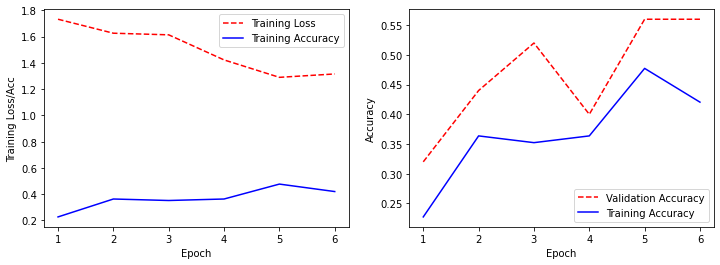

In [47]:
# Get training and test loss histories
training_loss = history.history['loss']
training_acc = history.history['accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

fig=plt.figure(figsize=(12, 4))
# Visualize loss history
fig.add_subplot(121)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, training_acc, 'b-')
plt.legend(['Training Loss', 'Training Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Training Loss/Acc')

# Get training and test loss histories
val_acc = history.history['val_accuracy']
training_acc = history.history['accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(val_acc) + 1)

# Visualize loss history
fig.add_subplot(122)
plt.plot(epoch_count, val_acc, 'r--')
plt.plot(epoch_count, training_acc, 'b-')
plt.legend(['Validation Accuracy', 'Training Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show();

In [48]:
saveweight =  'celebriytag_weight.h5'
model.save_weights(saveweight)

### 4. Evaluation

In [49]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from io import BytesIO
import cv2
import requests
import os

In [ ]:
labels = ['ben_afflek',  'elton_john',  'jerry_seinfeld',  'madonna',  'mindy_kaling']
test_imgs = ['ben_afflek/httpabsolumentgratuitfreefrimagesbenaffleckjpg.jpg']

for test in test_imgs:
    test_img = os.path.join(validation_data_dir, test)
    img = image.load_img(test_img, target_size=(img_width, img_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.
    classes = model.predict(x)
    result = np.squeeze(classes)
    result_indices = np.argmax(result)
    
    img = cv2.imread(test_img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.title("{}, {:.2f}%".format(labels[result_indices], result[result_indices]*100))
    plt.imshow(img)
    
    #print("{}, {:.2f}%".format(labels[result_indices], result[result_indices]*100))